<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea17_electrical_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install dtw-python

In [ ]:
import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
from dtw import *
from scipy import stats

In [ ]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='fig_t16_serie.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [ ]:
## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [ ]:
def analogo_knn(serie,vsele,k=10,tol=0.7,n_components=3,typedist='pearson',typereg='OLS',verbose=False):    
#    vsele      : Tamanio de la ventana de selección
#    k          : Número de vecinos a buscar k
#    tol        : Tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist   : medida de distancia, 'dtw' o 'euclidian' o 'pearson'

    t_o = time.time()
    n = len(serie) ## longitud total de la serie

    ## PASO 1: Selección de las ventanas de mayor correlación.

    ## Calculamos la distancia entre todos los vecinos.
    distances = []
    Y = serie[n-vsele:n]           ## últimos datos
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'euclidian':
            dist = euclidean(Y,serie[i:i+vsele])
        else:
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        if dist > 0:
            distances.append((i, dist))
        
    ## Calculamos el vecindario por distancia de menor a mayor y se guardan las posiciones.
    if typedist == 'pearson':
        ## En caso de pearson se ordena al revés, nos interesan los mayor correlación.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        ## En caso de pearson se ordena al revés, nos interesan los de menor distancia.
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## Calculamos los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## si ya teniamos una posición en la lista que pase la tolerancia, ya no la guardamos 
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## Guarda nuevo vecino
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## posición de los k vecinos mas cercanos

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)
        print_serie2(neighbors2,vacia,'Posteriores:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

    ## PASO 2: Regresión entre los vecinos mas cercanos 'X' y la última ventana 'Y'

    ## Definimos nuestros CLASIFICADORES   
    #X   = (neighbors.T).tolist()
    #X_2 = (neighbors2.T).tolist()
    #Y   = (Y).tolist()
    #prediction_Y2 = []
    t_reg=0
    t_sel=0
    prediction_Y2=0
    return prediction_Y2, t_sel, t_reg

In [ ]:
## https://github.com/urieliram/statistical/blob/main/Tarea13.ipynb
#serie = [1,1,7,7,9,8,1,8,7,0,2,7,6,1,1,6,6,5,9,2,7,9,0,1,2,9,7,9,2,0,7,5,5,5,5,7,9
#,9,0,7,5,5,6,0,4,3,5,5,3,5,0,2,0,5,0,5,6,4,3,4,9,2,6,2,8,0,4,7,6,5,2,0,3,2
#,3,0,6,2,6,6,4,5,0,6,1,4,9,6,0,3,6,9,5,0,2,4,3,5,0,5,6,4,5,5,0,3,2,0,2,1,7
#,3,3,2,5,3,5,7,5,1,3,5,9,4,6,6,5,2,0,4,0,5,0,7,2,1,5,9,5,7,4,0,3,4,5,4,0,5
#,2,2,5,4,9,7,6,0,5,5,5,5,0,0,3,5,2,2,3,9,5,7,5,3,5,9,5,4,0,2,4,4,6,1,0,5,0
#,5,0,7,0,0,0,0,2,4,4,3,0,4,3,0,2,6,0,6,5,2,6,5,0,5,5,0,2,2,5,2,4,9,0,2,5,6
#,1,0,0,0,5,8,0,5,3,0,0,3,5,0,0,2,5,2,7,2,5,0,4,5,6,9,0,5,4,0]

serie = [1,1,7,7,9,8,1,8,7,0,2,7,6,1,1,6,6,5,9,2,7,9,0,1,2,9,7,9,2,0,7,5,5,5,5,7,
         9,9,0,7,5,5,6,0,4,3,5,5,5,5,0,2,0,5,5,5,6,4,3,4,9,2,6,2,8,0,4,7,6,5,2,0,
         3,2,0,0,6,2,6,6,4,5,0,6,1,4,9,6,0,3,6,9,5,0,2,4,3,5,0,5,6,4,5,5,0,3,2,0,
         2,1,7,3,5,2,5,3,5,6,5,1,3,5,9,4,6,6,5,2,0,4,0,5,0,7,2,1,5,9,5,7,3,0,3,4,
         5,3,0,5,2,2,5,4,9,7,6,0,5,5,5,5,0,0,3,5,2,5,3,9,5,7,5,3,5,9,5,4,0,2,4,4,
         6,1,0,5,0,5,0,7,0,0,0,0,2,4,4,3,0,4,3,0,2,6,0,6,5,2,6,5,0,5,5,0,2,2,5,2,
         4,9,0,2,5,6,1,0,0,0,5,8,0,5,3,0,0,3,5,0,0,5,5,5,7,2,5,0,4,5,6,0,0,5,4,0]


In [ ]:
nodes = np.unique(serie)
n = len(nodes)
A = np.zeros(shape=(n,n))

In [ ]:
for i in range(len(serie)-1):
    A[serie[i],serie[i+1]] = A[serie[i],serie[i+1]] + 1
A

array([[10.,  1.,  9.,  6.,  5., 12.,  3.,  4.,  0.,  0.],
       [ 2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  0.],
       [ 6.,  2.,  2.,  0.,  4.,  6.,  4.,  2.,  1.,  1.],
       [ 5.,  0.,  2.,  0.,  2.,  8.,  1.,  0.,  0.,  1.],
       [ 3.,  0.,  0.,  5.,  2.,  4.,  2.,  1.,  0.,  4.],
       [13.,  1.,  7.,  5.,  3., 16.,  6.,  4.,  1.,  4.],
       [ 5.,  4.,  2.,  0.,  3.,  6.,  3.,  0.,  0.,  1.],
       [ 2.,  0.,  2.,  2.,  0.,  3.,  3.,  1.,  0.,  4.],
       [ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 3.,  0.,  3.,  0.,  1.,  4.,  1.,  2.,  1.,  1.]])

In [ ]:
#G = nx.Graph()
G = nx.DiGraph()
G.add_nodes_from(nodes)

In [ ]:
rows = A.shape[0]
cols = A.shape[1]
for i in range(0, cols - 1):
    for j in range(0, rows -1):
        if A[i,j] != 0:
            G.add_edge(i, j)
            G.edges[i, j]['color'] = "red"


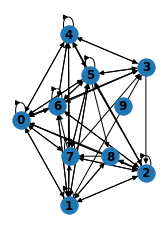

In [ ]:
subax1 = plt.subplot(121)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

[Creating a graph Networkx](https://networkx.org/documentation/stable/tutorial.html)

[Drawing graphs Networkx](https://networkx.org/documentation/stable/tutorial.html#drawing-graphs)

[A study of visibility graphs for time series representations](https://upcommons.upc.edu/bitstream/handle/2117/328691/152711.pdf?sequence=1&isAllowed=y)

positions KNN: [24, 191, 141, 1, 9, 84, 214, 115, 156, 66]


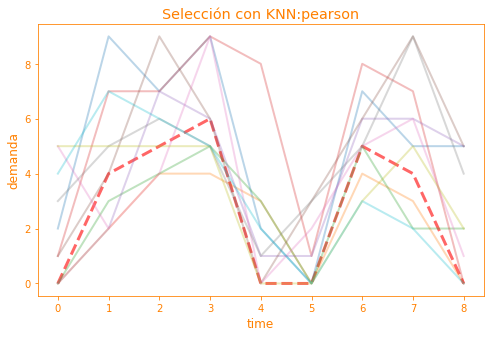

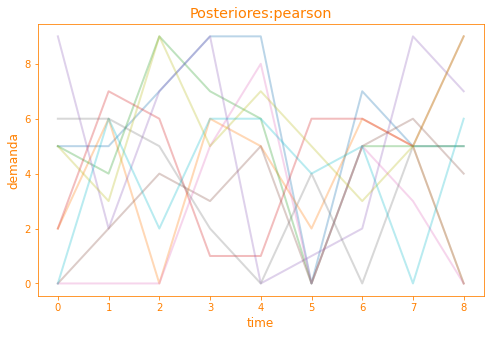

(0, 0, 0)

In [ ]:
analogo_knn(np.array(serie),vsele=9,k=10,tol=0.8,n_components=3,typedist='pearson',typereg='OLS',verbose=True)

In [ ]:
## Armamos miniseries de tamaño 'n' de atrás para adelante
mini = []
n = 10
for i in range(len(serie) - n + 1):
    aux=[]
    for j in range(n):
        aux.append(serie[i+j])
    mini.append(aux)
#print('mini',mini)

df = pd.DataFrame(mini)

X = df.loc[:,:n-2] ## Predictors
y = df.loc[:,n-1:]

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
bos = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42).fit(X_train, y_train)
bos.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1111111111111111

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
ada.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.23976608187134502

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
rf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.14035087719298245

In [ ]:
#score = AutoRF(X_train,y_train,X_test,y_test,verbose_=True)
#print(score)

In [ ]:
def AutoRF(X, Y, X_2, Y_2,verbose_=False):
## https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    nestlist = []
    for i in range(100, 300, 100):
        nestlist.append(i)
    param_grid = { 
        'bootstrap': [True, False],
        'n_estimators': nestlist,
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],}

    model   = RandomForestClassifier(random_state=42)
    clf     = GridSearchCV(estimator=model, param_grid=param_grid, cv=5).fit(X, Y)
    model   = clf.best_estimator_
    results = model.fit(X, Y)
    scorerf = results.score(X_2, Y_2)
    #prediction_Y2 = results.predict(X_2)

    if verbose_==True:
        print('Parameters used')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split)) 
            
    return scorerf #, prediction_Y2   

[**Mark Tenenholtz**](https://twitter.com/marktenenholtz/status/1503702578860724227)

[**LightGBM/XGBoost**](https://neptune.ai/blog/xgboost-vs-lightgbm)